In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import random
import scipy.io as sio

# Function to set seeds for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed for reproducibility
seed = 240802
set_seed(seed)

# Define the RNN model
class painRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(painRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, x):
        rnn_out, hn = self.rnn(x)
        output = self.fc(rnn_out)
        return output, rnn_out  # Return both the final output and all hidden states

# Define parameters
input_size = 1  # Input feature size
hidden_size = 8  # Number of features in the hidden state
output_size = 2  # Output feature size
num_layers = 1  # Number of RNN layers
learning_rate = 1e-4 # [0.001 or 0.0001]
batch_size = 32
num_epochs = 100

# load input and output data
inputoutputs = sio.loadmat('InOutputs')
Inputs = inputoutputs['Inputs']
Outputs = inputoutputs['Outputs']

Xnp = []
ynp = []
for cond_i in range(len(Outputs)):
    Xnp.append(np.tile(Inputs[cond_i, :], (Outputs[cond_i][0].shape[0], 1)))
    ynp.append(Outputs[cond_i][0])
Xnp = np.expand_dims(np.vstack(Xnp), axis = 2)
ynp = np.vstack(ynp)
X   = torch.from_numpy(Xnp).to(torch.float32)
y   = torch.from_numpy(ynp).to(torch.float32)

# Create DataLoader
dataset    = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Instantiate the model, define the loss function and the optimizer
device = 'cpu' #torch.device("cpu")
model  = painRNN(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_epochs = []

# Training loop
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs, hidden_states = model(inputs)  # Capture both outputs and hidden states
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_epochs.append(loss.item())
    
    if ((epoch+1) % 10) == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        # with torch.no_grad():
        #     # validation data
        #     inputs, targets = inputs.to(device), targets.to(device)
        #     outputs, hidden_states = model(inputs)  # Capture both outputs and hidden states
        #     loss = criterion(outputs, targets)
        # 
        # 24.08.08
        #   Jiwoong suggests making model for participants and using actual ratings for validation.
         
# Example: Using the model to get outputs and hidden states
out_t, h_t = model(torch.from_numpy(np.expand_dims(Inputs, axis = 2)).to(torch.float32))
out_t = out_t.detach().numpy()
h_t   = h_t.detach().numpy()

# Save the hidden states using scipy.io.savemat
sio.savemat('HiddenLayers.mat', {'out_t': out_t, 'h_t': h_t, 'loss_epochs': loss_epochs})
print("Training & Saving complete!")

Epoch [10/100], Loss: 0.1345
Epoch [20/100], Loss: 0.1414
Epoch [30/100], Loss: 0.0919
Epoch [40/100], Loss: 0.1350
Epoch [50/100], Loss: 0.1325
Epoch [60/100], Loss: 0.1129
Epoch [70/100], Loss: 0.1185
Epoch [80/100], Loss: 0.0800
Epoch [90/100], Loss: 0.0794
Epoch [100/100], Loss: 0.0874
Training & Saving complete!


Text(0, 0.5, 'click out')

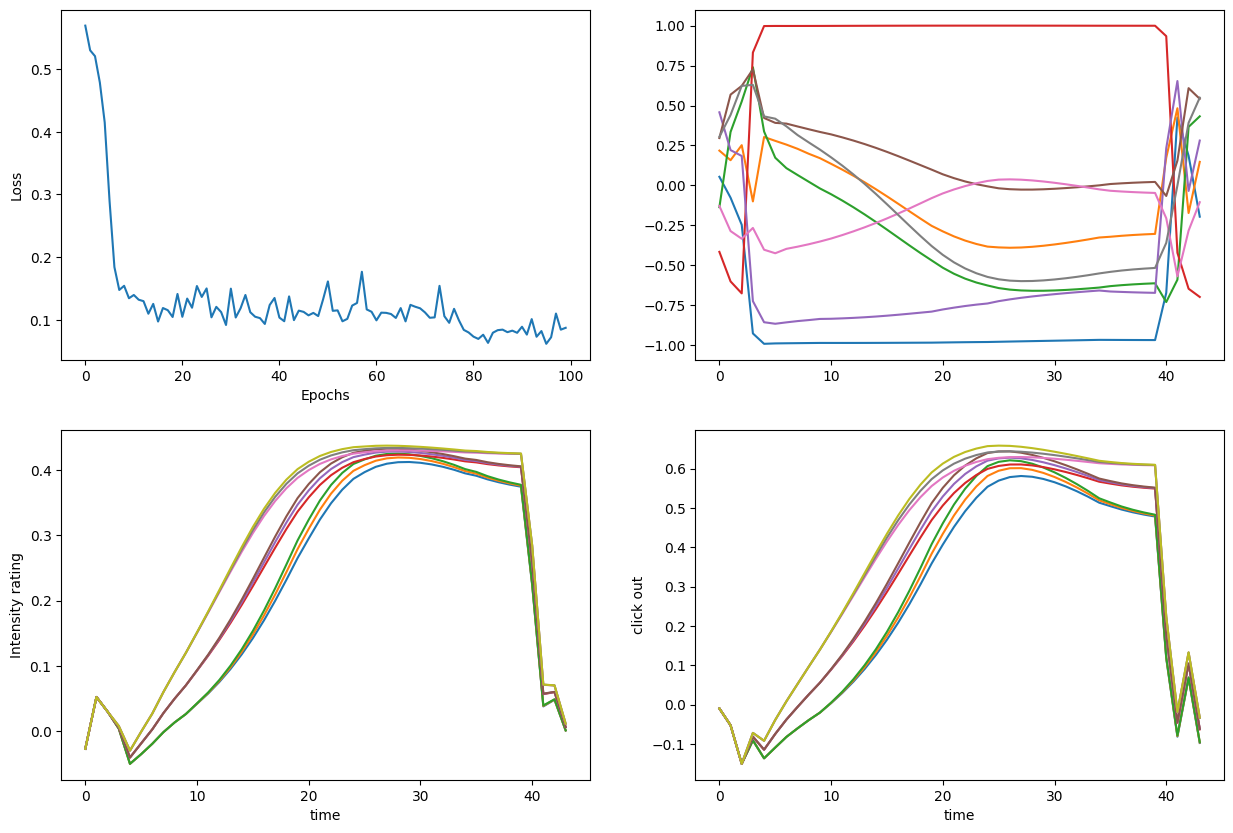

In [48]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize = (15, 10))
axes[0, 0].plot(loss_epochs)
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')

axes[0, 1].plot(np.mean(h_t, 0))
axes[1, 0].plot(out_t[:, :, 0].T)
axes[1, 0].set_xlabel('time')
axes[1, 0].set_ylabel('Intensity rating')
axes[1, 1].plot(out_t[:, :, 1].T)
axes[1, 1].set_xlabel('time')
axes[1, 1].set_ylabel('click out')

In [ ]:
X.dtype

torch.float64